<a href="https://colab.research.google.com/github/sleepypioneer/prompt_engineering/blob/main/CoRise_Week1_StudentVersion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is part of the course: [Prompt Design & Building AI products](https://corise.com/go/ai-products-NHKQNR) and is created by Sidharth Ramachandran as the project for Week 1 of the course.

# Generate your own Podcast 

Welcome to the project that is part of Week 1 of the course - Prompt Design & Building AI products. In this project, you are going to choose a book, topic, or paper of your choice & build your personlized podcast that discusses the key themes. 

The entire project is divided into the following three steps:

1. Build the text corpus for the subject of your choice
2. Summarizing and identifying the key themes using an LLM
3. Generating a podcast conversation that discusses the key themes
4. Giving a voice to the podcast and putting everything together


# The Problem

For many users, consuming information via an audio stream is more convenient than reading text. Many households are already familiar with using audio to access information on the Internet through virtual assistants and smart speakers. While they work well for information snippets and specific tasks ("Alexa, please play a lullaby!"), a conversational style is more effective in presenting information in an accessible and enjoyable way. This is why podcasts as a medium have become so popular.

But what if you wanted to listen to a podcast based on your current interest. Listening to a conversation about the Chola dynasty in 9th century CE India would be an absolute delight although something like this doesn't exist. What if you could create a podcast for any topic that catches your fancy? What if it could also be personalized the way you like - maybe you are not into the details and prefer a summary. Maybe you would also be happy to hear some witty jokes during the conversation. Maybe you like to hear guests with a deep and calming voice. In this project, we will try to build just the podcast for you! 

#Section 1: Build the text corpus for your topic of choice

You need to obtain the corpus of text content that will be the basis of your podcast. Depending on the topic you want to create a podcast about, there are several ways to collect the text. In the section below, we provide you with three options:

- PDF - text data from PDFs that are typically used for scientific papers, company reports, course notes and so on
- Wikipedia - the world encyclopedia 
- Text files - more generic source that can take it any text file

One could argue that Large Language Models (LLMs) being world models, they would already have all the information on the topic we care about. But there are some reasons why it still makes sense to consider creating your own text corpus:
1. LLMs typically have a certain cut-off date (e.g. August 2021 for chatGPT) and are trained on data that is not updated since. Therefore, it's likely that they do not have information about events and developments since that date. They might still be able to generate accurate responses but we can be less confident of their accuracy.
2. There are also data sources that are private (like emails, personal journals, company powerpoints) that LLMs do not have access to but which we would still like to use as the basis for generating a personalized podcast.
3. Using our own text corpus allows us to leverage the technical capabilities of the LLM while bringing our own intelligence, creativity and personal preferences to the task.

## Source Type: PDF

This is one of the ways in which we can import knowledge that is typically not indexed by search engines and generally private in nature. During the project kick-off I used an example of the annual report of a company but I'm sure that you will use something that is far more interesting and exciting 😃

In [ ]:
## Installing the necessary library to work with PDF
!pip install pypdf

We work with PDFs using the pypdf library. Provide the link to the URL to load the PDF.
If you only have a local copy of the PDF, then you can upload it to the Colab environment as shown in the two steps of the screenshot and then use the path of the uploaded file.

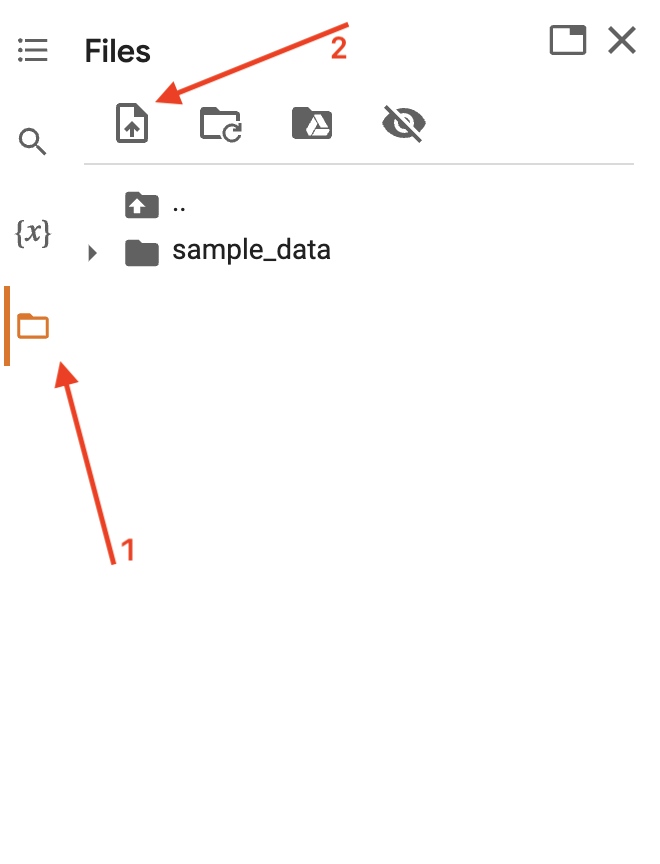

In [ ]:
import requests
import io
from pypdf import PdfReader, PageRange

# Replace the URL below with the specific PDF URL you want to use
URL = "YOUR_PDF_SOUCE_URL"
response = requests.get(URL)
response.raise_for_status()
remote_file_bytes = io.BytesIO(response.content)
reader = PdfReader(remote_file_bytes)

# Uncomment the below line and provide the path to the local PDF file you want to use
# reader = PdfReader("YOUR_PDF_LOCAL_PATH")

# Listing the number of pages in the PDF file
number_of_pages = len(reader.pages)
print (number_of_pages)

Depending on the number of pages and structure of your PDF, you may choose to only use a section of it. You can adapt the following code if you would like to pick certain sections of the PDF.

In [ ]:
pages = PageRange('START_PAGE:END_PAGE').to_slice()
selected_pages = reader.pages[pages]

# in case you want to use the entire document
# selected_pages = reader.pages

In [ ]:
pdf_input = ""
for page in selected_pages:
    pdf_input += page.extract_text() + "\n"

In [ ]:
pdf_input

## Source Type: Wikipedia

Wikipedia is a great source for gathering information about history, current events, celebrities and so much more! It's a good starting point for our text corpus.

In [ ]:
!pip install wikipedia

Let's confirm we can extract the content using Wikipedia's page about itself!

In [ ]:
import wikipedia
print (wikipedia.summary("Wikipedia"))

Using the Wikipedia library, we can get all the details of a certain Wiki page based on the title or the Wiki ID. 

- Feel free to choose a topic of your choice and retrieve those information from the Wiki page

In [ ]:
# Replace the Wiki page below with the name of the Wiki page you would like to use
input = wikipedia.page("YOUR_WIKI_PAGE_HERE", auto_suggest=False)

In [ ]:
wiki_input = input.content
wiki_input

In [ ]:
print (len(wiki_input))

## Source Type: Generic Text File

In order to provide an even more generic option, we consider loading information of a book from Project Gutenberg which is available in the form of a text file. This can easily cover almost any other text based source of knowledge.

Please replace the book of your choice by browsing through the Porject Gutenberg library.

In [ ]:
import requests

def get_gutenberg_text(url):
    response = requests.get(url)
    response.encoding = 'utf-8'
    raw_text = response.text

    start_delimiter = "*** START OF THE PROJECT GUTENBERG EBOOK"
    end_delimiter = "*** END OF THE PROJECT GUTENBERG EBOOK"

    start_index = raw_text.find(start_delimiter)
    end_index = raw_text.find(end_delimiter)

    if start_index == -1 or end_index == -1:
        raise ValueError("Could not find start or end delimiter in the text.")

    start_index = raw_text.find("\n", start_index) + 1
    end_index = raw_text.rfind("\n", 0, end_index)

    return raw_text[start_index:end_index]

In [ ]:
# Replace the URL below with the specific Project Gutenberg book URL you want to read
book_url = "YOUR_BOOK_OF_CHOICE"
book_input = get_gutenberg_text(book_url)

print(book_input[:500])  # Print the first 500 characters of the book

In [ ]:
print (len(book_input))

## Understanding Tokens & the Context Window

You might have noticed that at the end of each type of data source we also checked how large it is. This might be number of pages in a PDF or how long the text was in the case of text from Wikipedia or Project Gutenberg.  

This is important because when working with LLMs, you must remember that each model-type has a restricted **context window**. This is the amount of text that you can use in the prompt for that model-type. For e.g. `text-davinci-003` and `gpt-3.5-turbo` can accept a maximum input of 4096 tokens whereas newer models like `gpt-4` can take upto 32k tokens (this API is still not public and has a waitlist). The pricing of requests to the OpenAI API is also based on the number of tokens, for e.g. `gpt-3.5-turbo` costs $0.002 / 1K tokens.

### But what are tokens?

Tokens are the level at which these LLMs operate. They are trained to predict the next token in order to complete the sentence and so could be viewed as analogous to words. However, this is not completely accurate as tokens can also be parts of words. Let's use the `tiktoken` library from OpenAI to see how an example sentence would be tokenized and also use that to estimate the total number of tokens in our input text. 

In [ ]:
!pip install tiktoken

In [ ]:
import tiktoken
enc = tiktoken.encoding_for_model("gpt-3.5-turbo")
token_list = enc.encode("CoRise is amazing!")

In [ ]:
token_list

In [ ]:
for token in token_list:
  print ("Token ", str(token), " decodes to ", enc.decode([token]))

So we can see that the way OpenAI tokenizes our text is not exactly analogous to words as the word - "CoRise" has been tokenized into three tokens - "Co", "R" & "ise". The way that a model tokenizes our text impacts how many tokens and therefore the length of text that can be accepted in a single API request as well as the pricing -> more token, more the cost!

Let's determine the number of tokens in our text corpus.

In [ ]:
## Please the variable as pdf_input, wiki_input, or book_input based on your choice
print ("Number of tokens in corpus ", len(enc.encode("YOUR_INPUT_CHOICE")))

Books are normally quite long and we should expect a large number of tokens, certainly beyong the context window of 4096 tokens! In comparison, we might expect a smaller number of tokens for Wikipedia articles or selected pages from a PDF.

We need to consider that in addition to the input text, we will also have to add the the Prompt that will provide instructions to the LLM. This is not considered a separate field and is counted towards the context window. Therefore, we need to find a way to deal with input texts that exceed the token limit. 

What would happen if we do not handle these scenarios - it would result in the tokens at the end of our content being cut-off and not actually sent in the request to the LLM. Depending on the use-case this may or may not have critical implications.

We will design a series of steps that will split the input text into multiple chunks that satisfy the prompt limit. This also means that we will have to make multiple requests to the API and then collate all the responses after all responses have been received. 

We will start by splitting the input text into logical sub-parts - sentences with the help of the NLTK library.

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

def split_text (input_text):
  split_texts = sent_tokenize(input_text)
  return split_texts

Once the entire input text has been broken up into sentences we now join them up in such a way that we create chunks for each prompt. We keep adding sentences to a prompt chunk till we reach the max token length for that prompt. We set the max_token_len = 2000 in this case to ensure that we have enough spare room for our prompt instruction.

In [ ]:
def create_chunks(split_sents, max_token_len=2000):
  current_token_len = 0
  input_chunks = []
  current_chunk = ""
  for sents in split_sents:
    sent_token_len = len(enc.encode(sents))
    if (current_token_len + sent_token_len) > max_token_len:
      input_chunks.append(current_chunk)
      current_chunk = ""
      current_token_len = 0
    current_chunk = current_chunk + sents
    current_token_len = current_token_len + sent_token_len
  if current_chunk != "":
    input_chunks.append(current_chunk)
  return input_chunks

You can try the splitting function on the input text that you have created to see what happens.

In [ ]:
split_sents = split_text(wiki_input)
input_chunks = create_chunks(split_sents, max_token_len=2000)

In [ ]:
len(input_chunks)

Identify how many chunks you have created and ensure that a chunk has not been trimmed at the middle of a sentence. We will move towards the next step of summarizing this information.

# Section 2: Summarizing the text corpus using an LLM

In this section we will design a prompt for the LLM to take in the input text corpus and create a summary. We do this to identify the key themes and highlights of the chosen topic so that we can subsequently generate the podcast script based on that.

Keep in mind that a generic summary will probably be too short and not have enough context to explore in a podcast discussion.

Please create an account with OpenAI that will allow us to access the API by visiting this [link](https://platform.openai.com) and creating an account with a method of your choice. Once created, please naviagate to the `Manage Accounts` section of your profile and look-up the `Usage` tab. By default, most new accounts automatically get $18 of credit to try the API and this should be enough for the purposes of this project.

Please also visit the `API Keys` tab and Create a new secret key and copy this and keep it available. We will use this API key in subsequent steps while making the API calls. 

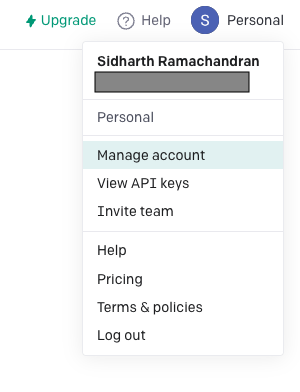


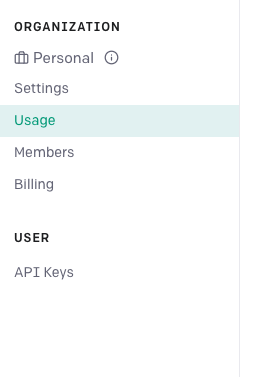

While we can use the API and make calls directly, it's much easier to work with the Python library provided by OpenAI called - `openai` 🤭. Let's install the package and also test whether it works with our API key.

In [ ]:
!pip install openai

Please paste *your* API credentials in the field specified below:

In [ ]:
import openai
from getpass import getpass

openai.api_key = getpass('Enter your OPENAI_API_KEY  ')

In [ ]:
# we can confirm that the API key works by listing all the OpenAI models
# we will be using the gpt-3.5-turbo version for this project
models = openai.Model.list()
for model in models["data"]:
  print (model["root"])

**Instructing chatGPT to create a summary from our source text corpus**

We are at the point where we have created chunks for our source text and now it's time to work with chatGPT to generate the summary for our podcast. Please fill in the text prompt below:

- Keep in mind that you don't want just a regular summary - there should be enough information to create a podcast conversation
- Keep in mind that information is returned in a structured way so that you can easily parse and re-use for the next step

In [ ]:
instructPrompt = """
YOUR PROMPT HERE
"""

In [ ]:
requestMessages = []
for text in input_chunks:
  requestMessage = instructPrompt + '\n' + text
  requestMessages.append(requestMessage)

In [ ]:
chatOutputs = []
for request in requestMessages:
  chatOutput = openai.ChatCompletion.create(model="gpt-3.5-turbo",
                                            messages=[{"role": "system", "content": "You are a helpful assistant."},
                                                      {"role": "user", "content": request}
                                                      ]
                                            )
  chatOutputs.append(chatOutput)

In [ ]:
podcastFacts = ""
for chats in chatOutputs:
  podcastFacts = podcastFacts + chats.choices[0].message.content

In [ ]:
podcastFacts

The above output should be a list of all important facts, themes or other highlights from your topic that you would like to be covered in the podcast conversation

# Section 3: Generating a podcast conversation script from the summarized text corpus using an LLM

We have the key highlights/facts from the text corpus. We would like to weave a podcast conversation around this and generate a podcast script. 

You can be as creative as you like and here are some options that you can use when constructing your prompt -  
- Introduce the speakers - give them names (celebrities perhaps?)
- Would you like to assign a personality to your speakers? Include details when setting the context in your prompt
- Add some information to have a gentle introduction - maybe an ice-breaker?
- Then provide instructions for how the conversation should proceed - who asks the questions, how does the other speaker respond?
- Keep in mind that you will use this output in the next step to generate voices, so have a way to identify the different speakers in the conversation

**Helpful Hints**

- In order to avoid using up a lot of your tokens it makes sense to start with only one chunk at a time and run experiments with your prompt. Once satisfied with the outcomes, then extend this to include all the chunks.
- Remember that in the next section, you are going to use a method to generate voices for the generated script. Therefore you should have a way to identify the speaker of each line of text so that you can generate the voice easily
- One of the possible ways to format the output of this section is as follows:

>Sid: Hey Darren, what are you drinking right now?
>
>Darren: Just some water. What about you?
>
>Sid: Oh, I've got a hot cup of coffee here. Can't function without it!
>
>Darren: Same here! So, what's new in the business world?



In [ ]:
podcastPrompt = """
YOUR_PROMPT_HERE
"""

In [ ]:
requestMessage = podcastPrompt + podcastFacts
requestMessage

In [ ]:
finalOutput = openai.ChatCompletion.create(model="gpt-3.5-turbo",
                                            messages=[{"role": "system", "content": "You are a helpful assistant."},
                                                      {"role": "user", "content": requestMessage}
                                                      ]
                                            )

In [ ]:
podcastScript = finalOutput.choices[0].message.content

In [ ]:
print (podcastScript)

Check the output script that your prompt generated and make necessary changes if required. Prompt design is iterative in nature and don't be shy to explore different styles.

# Section 4 - Generating the voice and putting the podcast together

We choose to perform the voice generation using voices from 11Labs (11.ai). They are a startup that provide realistic voices with the right intonation while speaking. They also offer the possibility to train your own voice (using the Studio/Web version but you can choose from the multiple options available to start with.

In order to sign-up, please visit this [link](https://beta.elevenlabs.io/) and create an account. Every new account receives free credits to run voice generations for upto 10k words which should fit well for the purposes of this project. Once the sign-up is complete, please click on the Account name and `Profile` tab from where you can copy the API key.

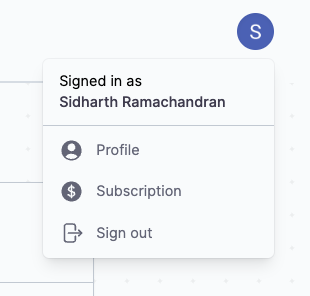

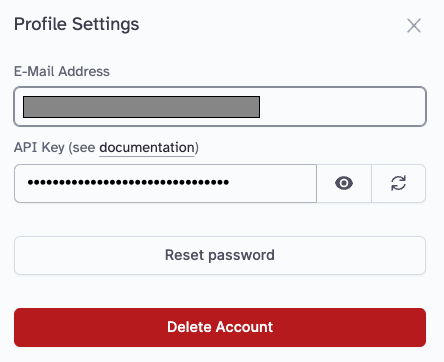

In [ ]:
!pip install elevenlabs

In [ ]:
from elevenlabs import set_api_key

set_api_key(getpass('Enter your ELEVEN_LABS_API_KEY  '))

You can select from a list of speakers that are offered by Eleven Labs as listed [here](https://beta.elevenlabs.io/) in their demo dropdown. Hit the play button to hear the voice and choose a speaker that appeals to you!

In order to perform the voice generation, you can use the method below. This assumes that each line of the input text is spoken by a different person and the person's name is also part of the text itself. Please ensure that the output of your podcast script fits this style or else feel free to adjust the method. 

Once you have selected the speaker voices then please make changes below to specify the name of the speakers you chose while generating the podcast script. This will ensure those names are actually removed before the dialogue is spoken!

In [ ]:
from elevenlabs import generate

def createPodcast(podcastScript, speakerName1, speakerChoice1, speakerName2, speakerChoice2):
  genPodcast = []
  podcastLines = podcastScript.split('\n\n')
  podcastLineNumber = 0
  for line in podcastLines:
    if podcastLineNumber % 2 == 0:
      speakerChoice = speakerChoice1
      line = line.replace(speakerName1+":", '')
    else:
      speakerChoice = speakerChoice2
      line = line.replace(speakerName2+":", '')
    genVoice = generate(text=line, voice=speakerChoice, model="eleven_monolingual_v1")
    genPodcast.append(genVoice)
    podcastLineNumber += 1
  return genPodcast

In [ ]:
speakerName1 = "YOUR_SPEAKER_ONE_NAME"
speakerChoice1 = "SPEAKER_ONE_VOICE"
speakerName2 = "YOUR_SPEAKER_TWO_NAME"
speakerChoice2 = "SPEAKER_TWO_VOICE"
genPodcast = createPodcast(podcastScript, speakerName1, speakerChoice1, speakerName2, speakerChoice2)

In [ ]:
type(genPodcast)

In [ ]:
with open("/content/sample_data/genPodcast.mpeg", "wb") as f:
  for pod in genPodcast:
    f.write(pod)

# Enjoy your very own podcast

I'm sure that you will notice several interesting aspects:
- Intonation like the Ah, Hmm etc.
- Notice when it might get things wrong as well!